In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
for module in ['hosts', 'targeting', 'utils']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [265]:
import time
import shutil

from lxml import html
import numpy  as np
np.seterr(invalid='ignore', divide='ignore')

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.utils.data import get_file_contents, download_file
from astropy.table import Table, vstack

In [34]:
anaK_coo = SkyCoord(354.13105403*u.deg, 0.29726505 *u.deg, distance=34.4*u.Mpc)

In [7]:
brickurl = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr1/decals-bricks.fits'
bricktab = Table(fits.HDUList.fromstring(get_file_contents(brickurl, cache=True))[1].data)

#re-assign the "has" columns from integers to bools
for cname in bricktab.colnames:
    if cname.startswith('has_'):
        bricktab[cname].dtype = bool

In [8]:
hasall = bricktab['has_image_g']&bricktab['has_image_r']&bricktab['has_image_z']&bricktab['has_catalog']
allbricktab = bricktab[hasall]

In [271]:
def point_in_brick(bricktab, raorsc, dec=None):
    if dec is None:
        ra = raorsc.ra
        dec = raorsc.dec
    else:
        ra = raorsc
    ra1msk = bricktab['ra1']<ra.deg
    ra2msk = ra.deg<bricktab['ra2']
    dec1msk = bricktab['dec1']<dec.deg
    dec2msk = dec.deg<bricktab['dec2']
    return ra1msk&ra2msk&dec1msk&dec2msk

def circle_in_brick(bricktab, center, radius):
    
    ras = [[b['ra1'], b['ra1'], b['ra2'], b['ra2']] for b in bricktab]
    decs = [[b['dec1'], b['dec2'], b['dec1'], b['dec2']] for b in bricktab]
    
    
    if radius.unit.is_equivalent(u.deg):
        brickcorners = SkyCoord(ras*u.deg, decs*u.deg)
        brickcornersin = anaK_coo.separation(brickcorners) < radius
    elif radius.unit.is_equivalent(u.kpc):
        brickcorners = SkyCoord(ras*u.deg, decs*u.deg, distance=center.distance)
        brickcornersin = anaK_coo.separation_3d(brickcorners) < radius
        #radius = ((radius/center.distance)*u.rad).to(u.deg)
    else:
        raise ValueError('invalid unit on radius')
        
    return np.any(brickcornersin, axis=1)

In [64]:
anakonlyin = inbrick(allbricktab, anaK_coo.ra, anaK_coo.dec)
anakin = circle_in_brick(allbricktab, anaK_coo, 400*u.kpc)
np.sum(anakonlyin), np.sum(anakin)

(1, 34)

In [65]:
basecaturl = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr1/tractor/'
baseimurl = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr1/coadd/'

caturls = []
imdirsurls = []
for entry in allbricktab[anakin]:
    brickname = entry['brickname']
    dirname = brickname[:3]
    caturls.append(basecaturl + '{dirname}/tractor-{brickname}.fits'.format(**locals()))
    imdirsurls.append(baseimurl + '{dirname}/{brickname}/'.format(**locals()))

In [87]:
#download the images to a local dir because they are quite big
todl = []
for imdir in imdirsurls:
    tree = html.parse(imdir)
    hrefs = [a.attrib['href'] for a in tree.findall(".//a")]
    #todl.extend([imdir+href for href in hrefs if '-image' in href or '-model' in href or '-resid' in href])
    todl.extend([imdir+href for href in hrefs if '-image-r.fits' in href or 
                                                 '-image.jpg' in href or 
                                                 '-model-r.fits.gz' in href or
                                                 '-model.jpg' in href])
print([i.split('/')[-1] for i in todl])

['decals-3536m002-image-r.fits', 'decals-3536m002-image.jpg', 'decals-3536m002-model-r.fits.gz', 'decals-3536m002-model.jpg', 'decals-3538m002-image-r.fits', 'decals-3538m002-image.jpg', 'decals-3538m002-model-r.fits.gz', 'decals-3538m002-model.jpg', 'decals-3541m002-image-r.fits', 'decals-3541m002-image.jpg', 'decals-3541m002-model-r.fits.gz', 'decals-3541m002-model.jpg', 'decals-3543m002-image-r.fits', 'decals-3543m002-image.jpg', 'decals-3543m002-model-r.fits.gz', 'decals-3543m002-model.jpg', 'decals-3546m002-image-r.fits', 'decals-3546m002-image.jpg', 'decals-3546m002-model-r.fits.gz', 'decals-3546m002-model.jpg', 'decals-3533p000-image-r.fits', 'decals-3533p000-image.jpg', 'decals-3533p000-model-r.fits.gz', 'decals-3533p000-model.jpg', 'decals-3536p000-image-r.fits', 'decals-3536p000-image.jpg', 'decals-3536p000-model-r.fits.gz', 'decals-3536p000-model.jpg', 'decals-3538p000-image-r.fits', 'decals-3538p000-image.jpg', 'decals-3538p000-model-r.fits.gz', 'decals-3538p000-model.jpg',

In [88]:
dlednames = []
for i, url in enumerate(todl):
    print('On file', i+1, 'of', len(todl))
    targetname = os.path.join('decals_images', url.split('/')[-1])
    dlednames.append(targetname)
    if os.path.isfile(targetname):
        print('File', targetname, 'exists, skipping')
        continue
    st = time.time()
    dlname = download_file(url, cache=False)
    print('Took', time.time()-st, 'sec. Moving', dlname, 'to', targetname)
    shutil.move(dlname, targetname)

On file 1 of 136
File decals_images/decals-3536m002-image-r.fits exists, skipping
On file 2 of 136
File decals_images/decals-3536m002-image.jpg exists, skipping
On file 3 of 136
Took 52.4696760178 sec. Moving /var/folders/7_/0n3gbrls1sb2vn6xjprw8c280000gn/T/tmpe7IMyb to decals_images/decals-3536m002-model-r.fits.gz
On file 4 of 136
Took 1.33755207062 sec. Moving /var/folders/7_/0n3gbrls1sb2vn6xjprw8c280000gn/T/tmpkMxAV5 to decals_images/decals-3536m002-model.jpg
On file 5 of 136
File decals_images/decals-3538m002-image-r.fits exists, skipping
On file 6 of 136
File decals_images/decals-3538m002-image.jpg exists, skipping
On file 7 of 136
Took 64.2111768723 sec. Moving /var/folders/7_/0n3gbrls1sb2vn6xjprw8c280000gn/T/tmpsJDxho to decals_images/decals-3538m002-model-r.fits.gz
On file 8 of 136
Took 1.52127194405 sec. Moving /var/folders/7_/0n3gbrls1sb2vn6xjprw8c280000gn/T/tmptEd3sI to decals_images/decals-3538m002-model.jpg
On file 9 of 136
File decals_images/decals-3541m002-image-r.fits e

In [89]:
#build residual maps for all image/model sets
for fn in dlednames:
    if '-image-' in fn:
        modelfn = fn.replace('-image-', '-model-').replace('.fits', '.fits.gz')
        if modelfn not in dlednames:
            print('Found', fn, 'but no model image', modelfn)
        else:
            residfn = fn.replace('-image-', '-resid-')
            if os.path.isfile(residfn):
                print('Residual file', residfn, 'already exists.  Skipping.')
                continue
            ifn = fits.open(fn)
            modeldata = fits.getdata(modelfn)
            resid = ifn[0].data - modeldata
            ifn[0].data = resid
            print('Writing residual file', residfn)
            ifn.writeto(residfn)

Writing residual file decals_images/decals-3536m002-resid-r.fits
Writing residual file decals_images/decals-3538m002-resid-r.fits
Writing residual file decals_images/decals-3541m002-resid-r.fits
Writing residual file decals_images/decals-3543m002-resid-r.fits
Writing residual file decals_images/decals-3546m002-resid-r.fits
Writing residual file decals_images/decals-3533p000-resid-r.fits
Writing residual file decals_images/decals-3536p000-resid-r.fits
Writing residual file decals_images/decals-3538p000-resid-r.fits
Writing residual file decals_images/decals-3541p000-resid-r.fits
Writing residual file decals_images/decals-3543p000-resid-r.fits
Writing residual file decals_images/decals-3546p000-resid-r.fits
Writing residual file decals_images/decals-3548p000-resid-r.fits
Writing residual file decals_images/decals-3533p002-resid-r.fits
Writing residual file decals_images/decals-3536p002-resid-r.fits
Writing residual file decals_images/decals-3538p002-resid-r.fits
Residual file decals_imag

In [67]:
#now actually download the catalogs
cattabs = [Table(fits.HDUList.fromstring(get_file_contents(url, cache=True))[1].data) for url in caturls]

# Now do actual analysis for AnaK field 

In [95]:
cattabs[0]

brickid,brickname,objid,brick_primary,blob,type,ra,ra_ivar,dec,dec_ivar,bx,by,bx0,by0,left_blob,decam_flux [6],decam_flux_ivar [6],"decam_apflux [6,8]","decam_apflux_resid [6,8]","decam_apflux_ivar [6,8]",decam_mw_transmission [6],decam_nobs [6],decam_rchi2 [6],decam_fracflux [6],decam_fracmasked [6],decam_fracin [6],out_of_bounds,decam_anymask [6],decam_allmask [6],wise_flux [4],wise_flux_ivar [4],wise_mw_transmission [4],wise_nobs [4],wise_fracflux [4],wise_rchi2 [4],dchisq [4],fracDev,fracDev_ivar,shapeExp_r,shapeExp_r_ivar,shapeExp_e1,shapeExp_e1_ivar,shapeExp_e2,shapeExp_e2_ivar,shapeDev_r,shapeDev_r_ivar,shapeDev_e1,shapeDev_e1_ivar,shapeDev_e2,shapeDev_e2_ivar,ebv,sdss_run,sdss_camcol,sdss_field,sdss_id,sdss_objid,sdss_parent,sdss_nchild,sdss_objc_type,sdss_objc_flags,sdss_objc_flags2,sdss_flags [5],sdss_flags2 [5],sdss_tai [5],sdss_ra,sdss_ra_ivar,sdss_dec,sdss_dec_ivar,sdss_psf_fwhm [5],sdss_mjd,sdss_theta_dev [5],sdss_theta_deverr [5],sdss_ab_dev [5],sdss_ab_deverr [5],sdss_theta_exp [5],sdss_theta_experr [5],sdss_ab_exp [5],sdss_ab_experr [5],sdss_fracdev [5],sdss_phi_dev_deg [5],sdss_phi_exp_deg [5],sdss_psfflux [5],sdss_psfflux_ivar [5],sdss_cmodelflux [5],sdss_cmodelflux_ivar [5],sdss_modelflux [5],sdss_modelflux_ivar [5],sdss_devflux [5],sdss_devflux_ivar [5],sdss_expflux [5],sdss_expflux_ivar [5],sdss_extinction [5],sdss_calib_status [5],sdss_resolve_status
int32,string64,int32,bool,int32,string32,float64,float32,float64,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,uint8,float32,float32,float32,float32,bool,int16,int16,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,int16,int16,int64,int16,int16,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32
330342,3536m002,0,False,0,PSF,353.753977987,5.49316e+09,-0.380404229687,5.91708e+09,27.3149,7.66982,28.0,8.0,False,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.872142 .. 0.964221,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,False,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.993719 .. 0.999688,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,139.533 .. 131.502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0371795,0,0,0,0,0,0,0,0,0,0,0 .. 0,0 .. 0,0.0 .. 0.0,353.753928123,0.0,-0.380380200839,0.0,0.0 .. 0.0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0
330342,3536m002,1,False,1,PSF,353.747954063,1.45843e+12,-0.379543811966,1.57489e+12,110.085,19.4937,109.98,19.1294,False,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.871674 .. 0.964083,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,False,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.993694 .. 0.999687,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,45476.9 .. 45473.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0373254,4263,3,74,245,1237663783657799925,244,0,6,268567056,8208,402685968 .. 402686480,64 .. 64,4576013943.96 .. 4576014015.67,353.747961697,49485296656.8,-0.379570318948,57501621525.7,1.06969 .. 0.872073,52963,0.101704 .. 0.0785822,0.0962446 .. 0.532991,0.148855 .. 0.338863,62.3977 .. 246.187,0.153044 .. 0.138043,0.231894 .. 0.341173,0.165774 .. 0.121528,39.2922 .. 124.638,1.0 .. 0.0,-132.011 .. -74.9163,-131.651 .. -75.5289,3.92214 .. 4.99823,14.9687 .. 1.97289,3.90849 .. 5.15852,15.1657 .. 1.40041,3.83192 .. 5.06134,17.1756 .. 1.75623,3.90849 .. 5.12942,15.1657 .. 1.41645,3.90186 .. 5.15852,15.2224 .. 1.40041,0.158221 .. 0.0471417,24577 .. 24577,257
330342,3536m002,2,False,1,EXP,353.748907611,2.02215e+11,-0

In [228]:
decamcat = vstack(cattabs)
decamscs = SkyCoord(ra=decamcat['ra']*u.deg, dec=decamcat['dec']*u.deg, distance=anaK_coo.distance)

In [229]:
nearanakmsk = decamscs.separation_3d(anaK_coo) < 300*u.kpc
np.sum(nearanakmsk), len(nearanakmsk)

(76519, 205094)

In [455]:
def mag_and_err(fluxidx, prefix):
    flux = decamcat[prefix + 'flux'][:, fluxidx]
    fluxivar = decamcat[prefix + 'flux_ivar'][:, fluxidx]
    
    mag = 22.5 - 2.5*np.log10(flux)
    merr = (2.5/np.log(10))* fluxivar**-0.5/flux
    
    return mag, merr

    
de_gmag, de_gerr = mag_and_err(1, prefix='decam_')
sdss_gmag, sdss_gerr = mag_and_err(1, prefix='sdss_cmodel')
de_rmag, de_rerr = mag_and_err(2, prefix='decam_')
sdss_rmag, sdss_rerr = mag_and_err(2, prefix='sdss_cmodel')
de_zmag, de_zerr = mag_and_err(4, prefix='decam_')
sdss_zmag, sdss_zerr = mag_and_err(4, prefix='sdss_cmodel')

de_rads = np.select([decamcat['type']=='PSF ', decamcat['type']=='EXP ', decamcat['type']=='DEV ', decamcat['type']=='COMP'],
                    [0.9, decamcat['shapeExp_r'], decamcat['shapeDev_r'], (decamcat['shapeExp_r'] + decamcat['shapeDev_r'])/2])

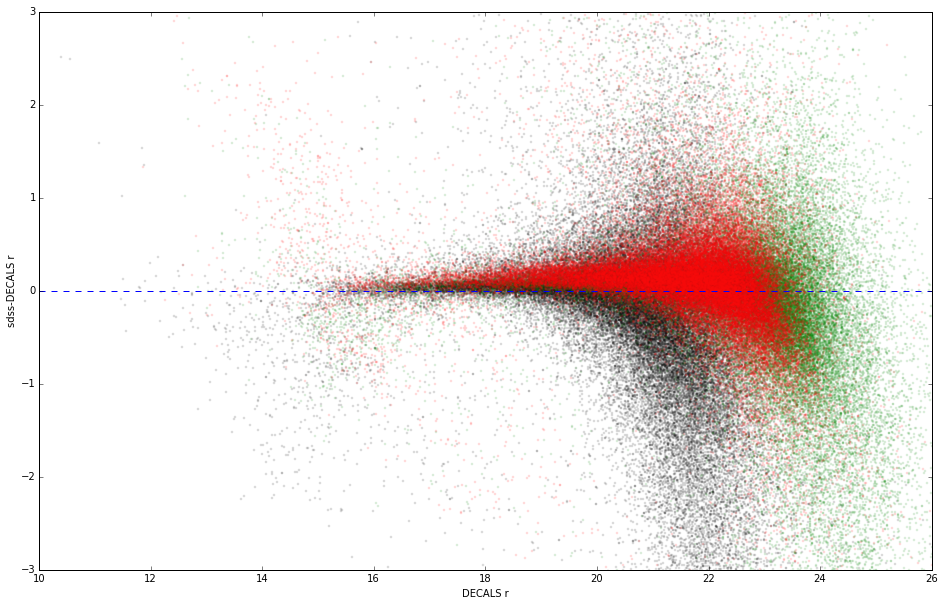

In [231]:
plt.scatter(de_zmag, sdss_zmag-de_zmag,color='k',alpha=.1,s=3)
plt.scatter(de_gmag, sdss_gmag-de_gmag,color='g',alpha=.1,s=3)
plt.scatter(de_rmag, sdss_rmag-de_rmag,color='r',alpha=.1,s=3)
plt.xlim(10,26)
plt.ylim(-3,3)
plt.axhline(0, color='b', ls='--')
plt.ylabel('sdss-DECALS r')
plt.xlabel('DECALS r')

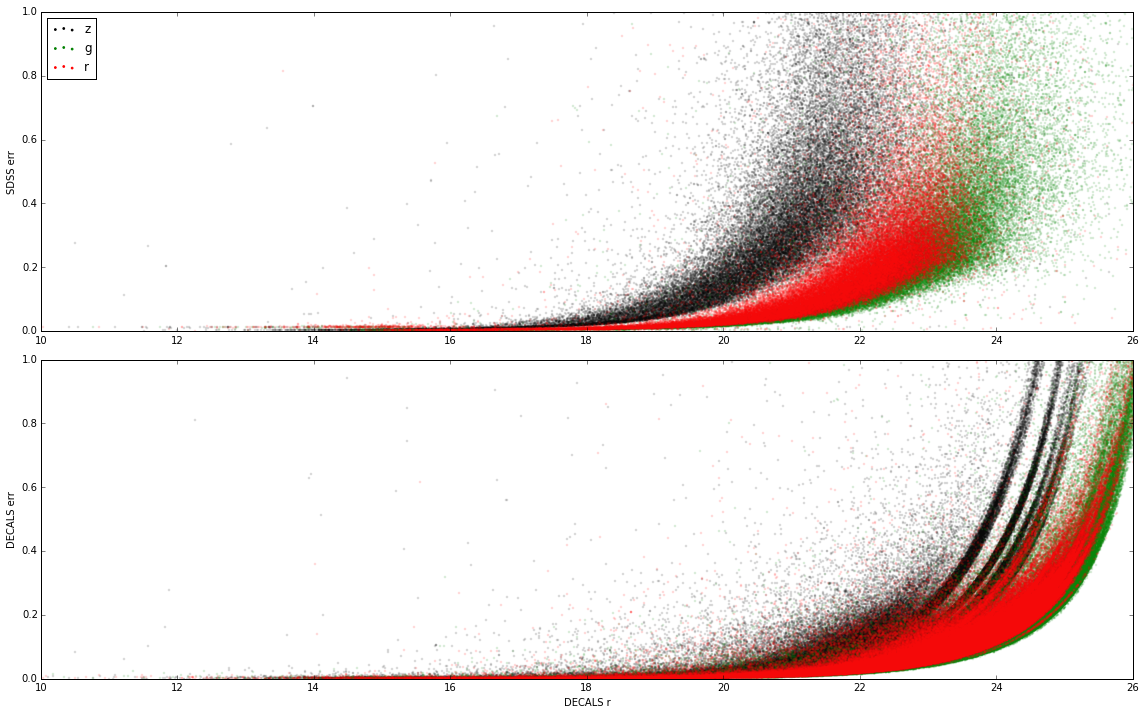

In [232]:
plt.subplot(2,1,1)
plt.scatter(de_zmag, sdss_zerr,color='k',alpha=.1,s=3, label='z')
plt.scatter(de_gmag, sdss_gerr,color='g',alpha=.1,s=3, label='g')
plt.scatter(de_rmag, sdss_rerr,color='r',alpha=.1,s=3, label='r')
[h.set_alpha(1) for h in plt.legend(loc='upper left').legendHandles]
plt.xlim(10,26)
plt.ylim(0,1)
plt.ylabel('SDSS err')

plt.subplot(2,1,2)
plt.scatter(de_zmag, de_zerr,color='k',alpha=.1,s=3)
plt.scatter(de_gmag, de_gerr,color='g',alpha=.1,s=3)
plt.scatter(de_rmag, de_rerr,color='r',alpha=.1,s=3)
plt.xlim(10,26)
plt.ylim(0,1)
plt.ylabel('DECALS err')
plt.xlabel('DECALS r')
plt.tight_layout()

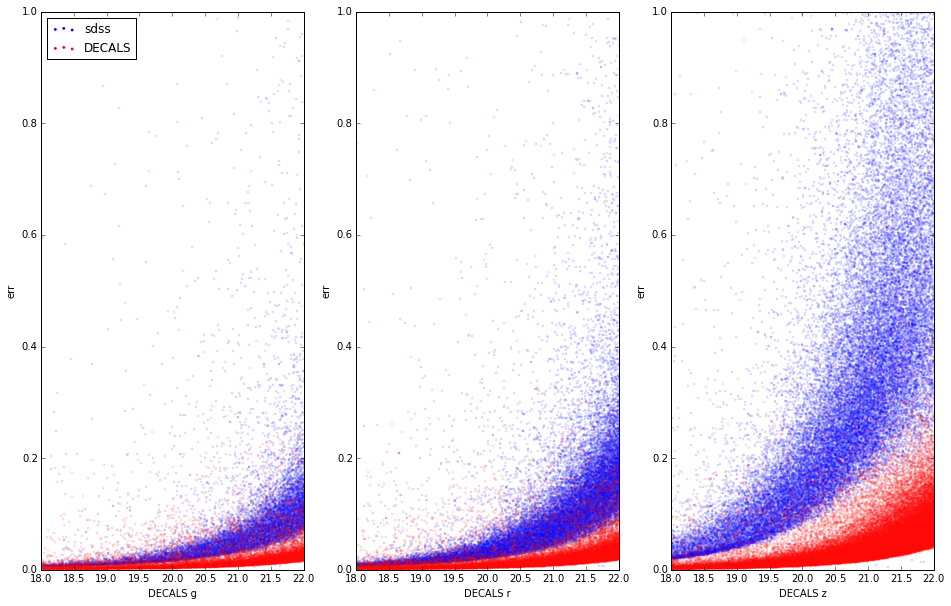

In [233]:
plt.subplot(1,3,1)
plt.scatter(de_gmag, sdss_gerr,color='b',alpha=.1,s=3,label='sdss')
plt.scatter(de_gmag, de_gerr,color='r',alpha=.1,s=3,label='DECALS')
[h.set_alpha(1) for h in plt.legend(loc='upper left').legendHandles]
plt.xlim(18,22)
plt.ylim(0,1)
plt.xlabel('DECALS g')
plt.ylabel('err')

plt.subplot(1,3,2)
plt.scatter(de_rmag, sdss_rerr,color='b',alpha=.1,s=3,label='sdss')
plt.scatter(de_rmag, de_rerr,color='r',alpha=.1,s=3,label='DECALS')
plt.xlim(18,22)
plt.ylim(0,1)
plt.xlabel('DECALS r')
plt.ylabel('err')

plt.subplot(1,3,3)
plt.scatter(de_zmag, sdss_zerr,color='b',alpha=.1,s=3,label='sdss')
plt.scatter(de_zmag, de_zerr,color='r',alpha=.1,s=3,label='DECALS')
plt.xlim(18,22)
plt.ylim(0,1)
plt.xlabel('DECALS z')
plt.ylabel('err')

# Try x-matching with sdss catalog

In [234]:
sdsscat = Table.read('catalogs/AnaK_sdss.dat', format='csv')
sdssscs = SkyCoord(sdsscat['ra']*u.deg, sdsscat['dec']*u.deg, distance=anaK_coo.distance)

In [245]:
sdss30am_msk = sdssscs.separation(anaK_coo) <= 30*u.arcmin
decam30am_msk = decamscs.separation(anaK_coo) <= 30*u.arcmin

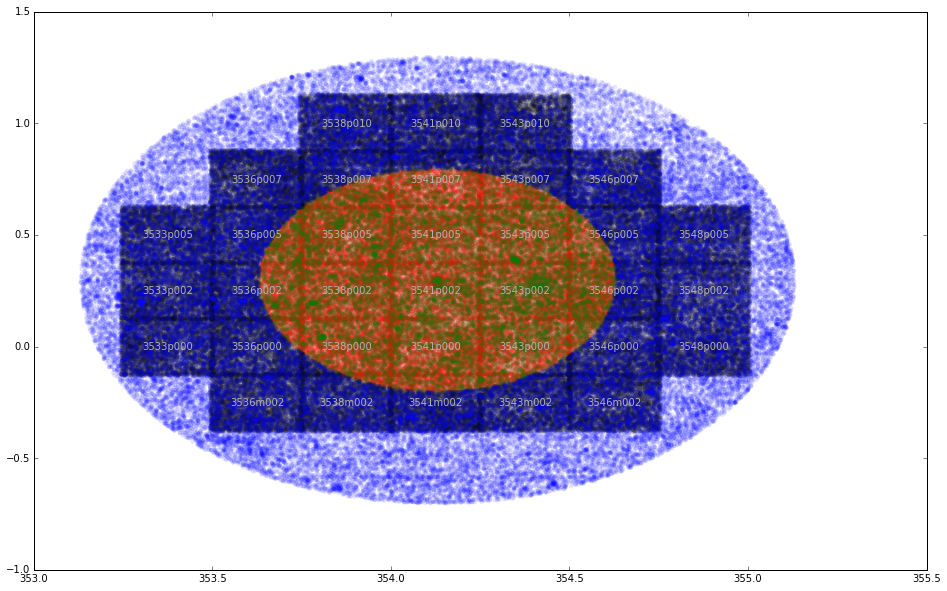

In [473]:
plt.scatter(decamscs.ra[decam30am_msk], decamscs.dec[decam30am_msk], alpha=.1, facecolor='r',edgecolor='none')
plt.scatter(decamscs.ra[~decam30am_msk], decamscs.dec[~decam30am_msk], alpha=.1, facecolor='k',edgecolor='none')
plt.scatter(sdssscs.ra[sdss30am_msk], sdssscs.dec[sdss30am_msk], alpha=.1, facecolor='g',edgecolor='none')
plt.scatter(sdssscs.ra[~sdss30am_msk], sdssscs.dec[~sdss30am_msk], alpha=.1, facecolor='b',edgecolor='none')
for brickentry in allbricktab[anakin]:
    plt.text(brickentry['ra'], brickentry['dec'], brickentry['brickname'], ha='center', va='center', color=[0.7]*3)

In [458]:
sdssscs30am = sdssscs[sdss30am_msk]
sdsscat30am = sdsscat[sdss30am_msk]
decamscs30am = decamscs[decam30am_msk]
decamcat30am = decamcat[decam30am_msk]
de_rmag30am = de_rmag[decam30am_msk]
de_rads30am = de_rads[decam30am_msk]

### Things in SDSS but not DECam 

(198, 0.038312693498452011)

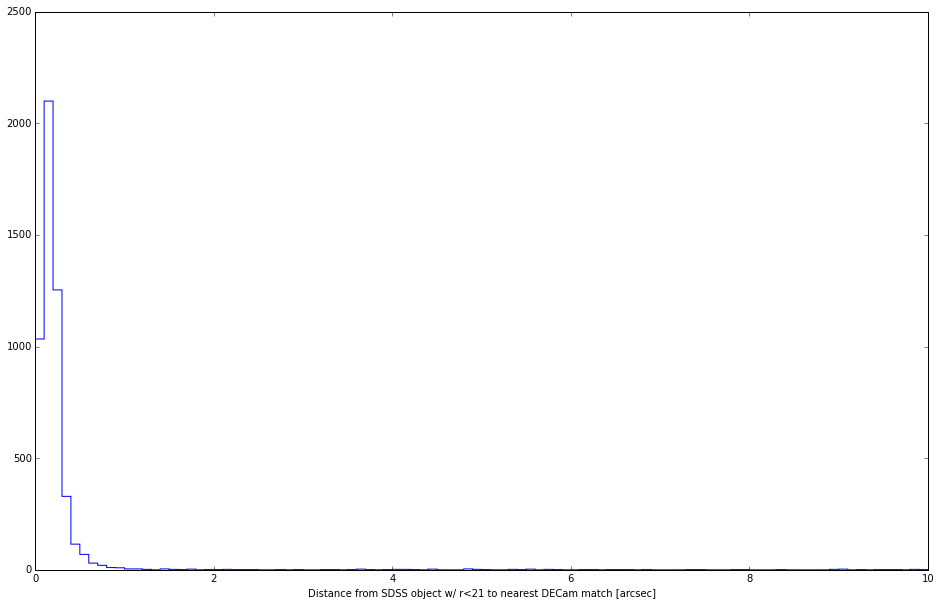

In [487]:
idx, d2d, d3d = sdssscs30am[sdsscat30am['r']<21].match_to_catalog_sky(decamscs30am[de_rmag30am < 22])
plt.hist(d2d.arcsec,bins=100,histtype='step',range=(0,10))
plt.xlabel('Distance from SDSS object w/ r<21 to nearest DECam match [arcsec]')
np.sum(d2d.arcsec>1), np.sum(d2d.arcsec>1)/len(d2d)

In [260]:
targeting.sampled_imagelist(sdssscs30am[sdsscat30am['r']<21][d2d.arcsec>1], None, names=sdsscat30am[sdsscat30am['r']<21]['r'][d2d.arcsec>1]);

### Things in DECam but not SDSS 

(979, 0.12973760932944606)

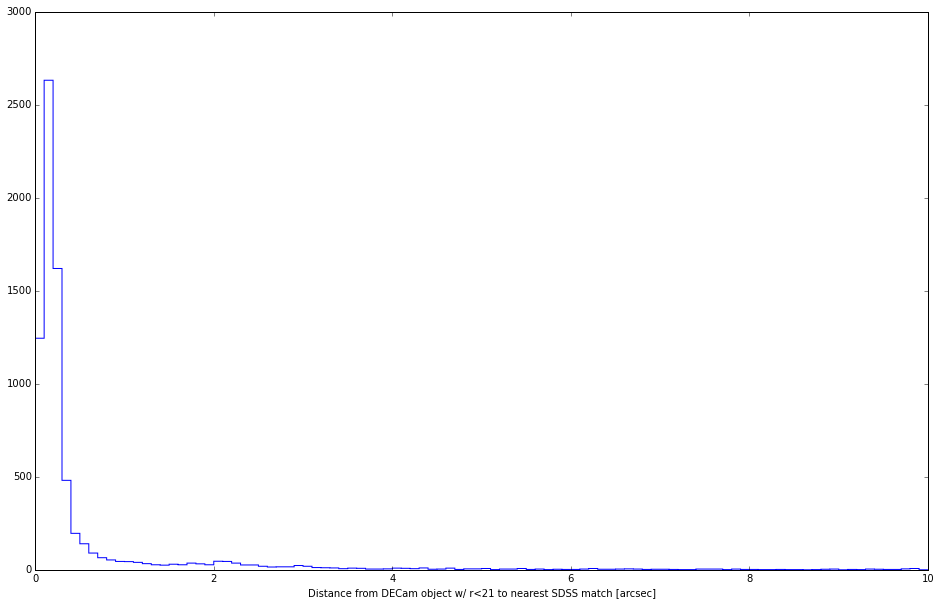

In [490]:
idx, d2d, d3d = decamscs30am[de_rmag30am < 21].match_to_catalog_sky(sdssscs30am)
plt.hist(d2d.arcsec,bins=100,histtype='step',range=(0,10))
plt.xlabel('Distance from DECam object w/ r<21 to nearest SDSS match [arcsec]')
np.sum(d2d.arcsec>1), np.sum(d2d.arcsec>1)/len(d2d)

In [492]:
targeting.sampled_imagelist(decamscs30am[de_rmag30am < 21][d2d.arcsec>1], None, None, names=de_rmag30am[de_rmag30am < 21][d2d.arcsec>1])

'name ra dec\n16.3621044159 354.00626529 0.523365333261\n19.2623462677 354.608962703 0.238686219072\n19.8555355072 354.373857573 0.535485109906\n19.2421875 354.176189592 0.210291189932\n19.7043228149 354.419539403 0.392786193952\n19.9254550934 354.12632167 0.268598680519\n19.9657802582 353.844255404 0.314772713349\n17.6725521088 353.83863269 0.315334216876\n19.2083969116 354.132202755 0.273054762385\n18.8328018188 354.50419749 0.579660843132\n20.2462615967 354.41933457 0.391038621463\n20.4498538971 354.124152251 0.262592224572\n20.9464035034 354.167162614 0.718580967611\n18.3768939972 353.773373445 0.199841699846\n20.8368873596 353.767671938 0.175956410745\n20.2281112671 354.144132071 0.270540339667\n20.6542377472 354.28430039 0.634429759319\n20.2116146088 353.80732835 0.399336517437\n20.6555480957 353.767327004 0.186637386306\n18.4224891663 354.358845593 0.381389445496\n20.1195526123 353.807234482 -0.0619505228088\n20.1274623871 354.349780588 0.405779011082\n18.7529773712 354.32729875

Inspecting *all* of these reveals only a single object @ 354.282916,0.21135.  They're basically entirely false objects from star-spikes or deblender problems.

### new target

In [582]:
newtarget = SkyCoord(354.282916*u.deg, 0.21135*u.deg)
newtarget.to_string('hmsdms', sep=' ', precision=2)

u'23 37 07.90 +00 12 40.86'

In [581]:
allbricktab[point_in_brick(allbricktab, newtarget)]

brickname,brickid,brickq,brickrow,brickcol,ra,dec,ra1,ra2,dec1,dec2,has_image_g,has_image_r,has_image_z,has_catalog
string64,int32,int16,int32,int32,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool
3543p002,333225,3,361,1417,354.375,0.25,354.25,354.5,0.125,0.375,True,True,True,True


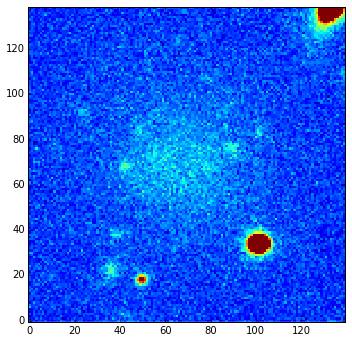

In [553]:
imgd = fits.getdata('decals_images/decals-3543p002-image-r.fits')

#estimated from the image
apcen = (3070.4872, 1266.6247)
aprad = 34.8

plt.figure(figsize=(5, 5))
plt.imshow(imgd[apcen[1]-aprad*2:apcen[1]+aprad*2, 
                apcen[0]-aprad*2:apcen[0]+aprad*2], vmin=-.02,vmax=.1)
plt.tight_layout()

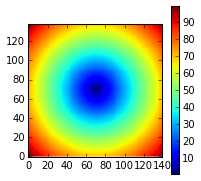

In [567]:
xg, yg = np.meshgrid(np.arange(imgd.shape[0]), np.arange(imgd.shape[1]))
dx = xg-apcen[0]
dy = yg-apcen[1]
dist = (dx*dx + dy*dy)**0.5
#use this to sanity check that the transposes are right and such
plt.figure(figsize=(3, 3))
plt.imshow(dist[apcen[1]-aprad*2:apcen[1]+aprad*2, 
                apcen[0]-aprad*2:apcen[0]+aprad*2])
plt.colorbar();

(18.509351063711748, 21.336375404855975, 20.47029935474184)

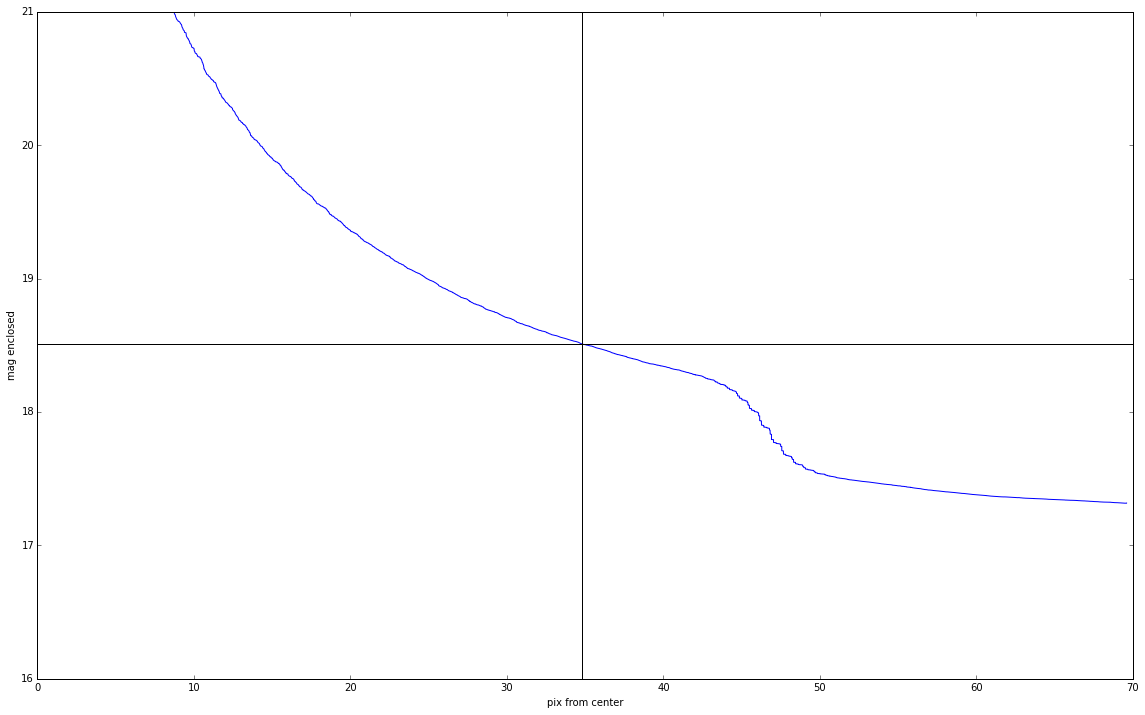

In [579]:
sorti = np.argsort(dist.ravel())
sortd = dist.ravel()[sorti]
dmsk = sortd<(aprad*2)
cumflux = np.cumsum(imgd.ravel()[sorti][dmsk])
mags = 22.5 - 2.5*np.log10(cumflux)
plt.plot(sortd[dmsk], mags)

plt.axvline(aprad, color='k')
apmag = np.interp(aprad, sortd[dmsk], mags)
plt.axhline(apmag, color='k')

fiber2mag = np.interp(2/0.2637, sortd[dmsk], mags)
fiber3mag = np.interp(3/0.2637, sortd[dmsk], mags)

plt.xlabel('pix from center')
plt.ylabel('mag enclosed')
plt.ylim(16,21)
plt.tight_layout()
apmag, fiber2mag, fiber3mag

### Check out some bricks to see what match/non-matches look like

This can be used to look at the DECALS bricks to compare the catalogs with SDSS.  Pick a brick, and choose it using the cell immediately below this one.  Then open up a ds9 window viewing whichever bands/images you want for that brick.  Then execute the rest of the cells to get regions marked in DS9 for various comparisons.

(Note that it's important this get executed *after* the preceding section: `d2d`, `idx`, and related variables are used here)

In [495]:
brick = '3543p002'

In [496]:
!ls decals_images/*{brick}*.fits

decals_images/decals-3543p002-image-r.fits decals_images/decals-3543p002-resid-r.fits


In [506]:
utils.skycoord_to_regions(newtarget) # for the interesting target above

In [500]:
#DECALS location of non-matched things
nonmatchcat = decamcat30am[de_rmag30am < 21][d2d.arcsec>1]
nonmatchscs = decamscs30am[de_rmag30am < 21][d2d.arcsec>1]
inbrick = nonmatchcat['brickname']==brick
utils.skycoord_to_regions(nonmatchscs[inbrick], 'circle', ['{0:.1f}" # color = red'.format(r) for r in de_rads30am[inbrick]])
utils.skycoord_to_regions(nonmatchscs[inbrick], 'text', ['"{0:.1f}"  # color = red'.format(m) for m in de_rmag30am[de_rmag30am < 21][d2d.arcsec>1][inbrick]])

In [485]:
#DECALS location of matches things
matchcat = decamcat30am[de_rmag30am < 21][d2d.arcsec<1]
matchscs = decamscs30am[de_rmag30am < 21][d2d.arcsec<1]
inbrick = matchcat['brickname']==brick
utils.skycoord_to_regions(matchscs[inbrick], 'circle', '0.7" # color = green')
utils.skycoord_to_regions(matchscs[inbrick], 'text', ['"{0:.1f}"  # color = green'.format(m) for m in de_rmag30am[de_rmag30am < 21][d2d.arcsec<1][inbrick]])


#the SDSS location of the matches
sdssmatchcat = sdsscat30am[idx[d2d.arcsec<1]]
sdssmatchscs = sdssscs30am[idx[d2d.arcsec<1]]
sscs = sdssmatchscs[decamcat30am[de_rmag30am < 21][d2d.arcsec<1]['brickname']==brick]
scat = sdssmatchcat[decamcat30am[de_rmag30am < 21][d2d.arcsec<1]['brickname']==brick]
utils.skycoord_to_regions(sscs, 'circle', '1.1" # color = blue')
utils.skycoord_to_regions(sscs, 'text', ['"{0:.1f}"  # color=blue'.format(m) for m in scat['r']])

In [507]:
#all DECALS objects in the brick
inbrick = decamcat['brickname']==brick

#utils.skycoord_to_regions(decamscs[inbrick], 'circle', ['{0:.1f}" # color = white'.format(r) for r in de_rads[inbrick]])
utils.skycoord_to_regions(decamscs[inbrick], 'text', ['"{0:.1f}"  # color = white'.format(m) for m in de_rmag[inbrick]])

In [508]:
#all SDSS objects in the brick
brickinfo = allbricktab[allbricktab['brickname']==brick]
inbrick = (brickinfo['ra1']<sdsscat['ra'])&(sdsscat['ra']<brickinfo['ra2'])&(brickinfo['dec1']<sdsscat['dec'])&(sdsscat['dec']<brickinfo['dec2'])

utils.skycoord_to_regions(sdssscs[inbrick], 'circle', '2.5" # color=magenta')
utils.skycoord_to_regions(sdssscs[inbrick], 'text', ['"{0:.1f}"  # color=magenta'.format(m) for m in sdsscat['r'][inbrick]])

#### Simple aperture photometry on the new target

requires brick 

In [509]:
f = fits.open('decals_images/decals-3543p002-image-r.fits')